In [1]:
%pip install pandas openpyxl scikit-learn numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from natasha import NewsEmbedding
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from functools import partial
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [ ]:
def create_feature_extractor(df_num, vector_embeddings):
    vect_columns = [f"vect_{i}" for i in range(vector_embeddings.shape[1])]
    df_vect = pd.DataFrame(vector_embeddings, columns=vect_columns)
    num_columns = df_num.columns

    combined_df = pd.concat([df_num.reset_index(drop=True), df_vect], axis=1)
    
    def get_num(X):
        return X[num_columns].values
    
    def get_vect(X):
        return X[vect_columns].values
    
    return combined_df, get_num, get_vect


def text_to_vector(emb, lemmas_doc, dimm=300): 
    vectors = []
    for sentence in lemmas_doc:
        for word in sentence:
            if word in emb:
                vectors.append(emb[word])
    
    if not vectors:
        return np.zeros(dimm)
    
    return np.mean(vectors, axis=0)


class PipelineBuilder:
    default_selector_k = 10

    def __init__(self, model_factory, get_num):
        self.get_num = get_num
        self.model_factory = model_factory
        self.include_std = False
        self.include_kbest = False
        self.vector_model_factory = None
        self.get_vect = None
        self.ensemble = None

    def use_std(self):
        self.include_std = True
        return self
    
    def use_kbest(self):
        self.include_kbest = True
        return self
    
    def use_vect(self, get_vect, model_factory=None, ensemble=None):
        self.vector_model_factory = model_factory
        self.get_vect = get_vect
        self.ensemble = ensemble
        return self
    
    def __build_num_pipeline(self):
        steps = [
            ('get_num', FunctionTransformer(self.get_num))
        ]
        
        if self.include_std:
            steps.append(('scaler', StandardScaler()))
            
        if self.include_kbest:
            steps.append(('selector', SelectKBest(k=PipelineBuilder.default_selector_k, score_func=mutual_info_classif)))
            
        return Pipeline(steps)
    
    def __build_ensemble(self, num_model, vect_model):
        model_factory, params = self.ensemble
        estimators = [
            ('vect_model', vect_model),
            ('num_model', num_model),
        ]   
        return model_factory(estimators=estimators, **params)

    def build(self):
        num_pipeline = self.__build_num_pipeline()

        # Только признаки
        if not self.get_vect:
            num_pipeline.steps.append(
                ('model', self.model_factory())
            )
            return num_pipeline
        
        vect_pipeline = Pipeline([
            ('get_vect', FunctionTransformer(self.get_vect, validate=False))
        ])
        
        # Общая модель для признаков
        if not self.vector_model_factory:
            return Pipeline([
                ('features', FeatureUnion([
                    ('num', num_pipeline),
                    ('vect', vect_pipeline)
                ])),
                ('model', self.model_factory())
            ])
        
        # Разные модели
        num_model = Pipeline(num_pipeline.steps + [('model', self.model_factory())])
        vect_model = Pipeline(vect_pipeline.steps + [('model', self.vector_model_factory())])
        
        return self.__build_ensemble(num_model, vect_model)
    
def create_accuracy(k_name, k_min, penalty_factor):    
    def accuracy_with_penalty(estimator, X, y):
        y_pred = estimator.predict(X)
        base_score = accuracy_score(y, y_pred)
        k = estimator.get_params().get(k_name, None)
        penalty = k / X.shape[1]

        if k > k_min:
            penalty = (1 - penalty_factor) ** (k - k_min)
            return base_score * penalty
        return base_score
    return accuracy_with_penalty

def get_best_models(pipeline_grids, X_train, y_train):
    results = []
    total = len(pipeline_grids)
    count = 0
    for (name, pipeline, grid, scoring) in pipeline_grids:
        print (f"{count + 1} / { total }")
        grid_search = GridSearchCV(pipeline, grid, cv=5, n_jobs=-1, scoring=scoring)
        grid_search.fit(X_train, y_train)
        results.append((name, grid_search))
        count+=1

    return results

def evaluate_quality(y_pred, y_test):
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(f"AUC = {roc_auc_score(y_test, y_pred)}")

def evaluate_models(models, X_test, y_test):
    for (name, model) in models:
        print(f'--------------{name}--------------')
        print(f'model parameters: {model.best_params_}')

        if hasattr(model.best_estimator_, 'named_steps'):
            if 'selector' in model.best_estimator_.named_steps:
                print(f'selected features: {model.best_estimator_.named_steps['selector'].get_feature_names_out()}')

            elif 'model' in model.best_estimator_.named_steps and hasattr(model.best_estimator_.named_steps['model'], 'feature_importances_'):
                feature_importances = model.best_estimator_.named_steps['model'].feature_importances_
                features_df = pd.DataFrame({'feature': [ f"x{i}" for i in range (model.best_estimator_.named_steps['model'].n_features_in_)], 'importance': feature_importances})
                features_df = features_df.sort_values(by='importance', ascending=False)
                print(features_df.head(10))


        y_pred = model.predict(X_test)
        evaluate_quality(y_pred, y_test)

def prepare_input(df, test_size, emb, feature_cols, target_col):
    vectors = np.vstack(df['lemm_sentences'].apply(partial(text_to_vector, emb)).values)
    X, get_num, get_vect = create_feature_extractor(df[feature_cols], vectors)
    X_train, X_test, y_train, y_test = train_test_split(X, df[target_col], test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test, get_num, get_vect

In [4]:
clean_data = pd.read_excel('./data/clean_data.xlsx', index_col=0)
noises_data = pd.read_excel('./data/with_noises.xlsx', index_col=0)
clean_data.head(5)

,Текст,Пол,length,mean_usage_[URL],mean_usage_[ADDRESS],mean_usage_[NUMBER],mean_usage_[QUOTE],mean_usage_[PUNCEM],mean_usage_[REMOVED],"mean_usage_,",...,mean_usage_DET,mean_usage_NUM,mean_usage_VERB,mean_usage_PART,mean_usage_PRON,mean_usage_SCONJ,mean_usage_sentence_length,mean_token_length,lemm_sentences,sentences_count
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,"Сегодня, моё беззаботное детство и суетливое н...",0,2062,0,0,0.000000,0.029412,0.058824,0,0.764706,...,0.235294,0.117647,1.411765,0.117647,0.205882,0,10.529412,6.893617,"[[""сегодня"", ""беззаботный"", ""детство"", ""суетли...",34
3,Спасибо большое Саше за помощь при регистрации...,0,1303,0,1,0.000000,0.000000,0.058824,0,1.058824,...,0.058824,0.000000,1.764706,0.117647,0.411765,0,13.176471,7.024000,"[[""спасибо"", ""большой"", ""ваш"", ""помощь"", ""реги...",17
4,Ох. Я заболела. Ну и пускай :) Давно со мной т...,0,1040,0,0,0.000000,0.045455,0.090909,0,0.636364,...,0.181818,0.000000,1.409091,0.090909,0.090909,0,8.636364,7.303371,"[[""ох""], [""заболеть""], [""пускай""], [""давно"", ""...",22
10,Двое не спят. Двое дымят папиросу любви. Им х...,0,1846,0,1,0.028571,0.114286,0.114286,1,1.028571,...,0.171429,0.142857,1.314286,0.085714,0.228571,0,10.514286,6.283871,"[[""двое"", ""спать""], [""двое"", ""дым"", ""папироса""...",35
11,"Я вспомнила, что когда-то проходила уже этот т...",0,3587,0,0,0.000000,0.100000,0.000000,1,1.200000,...,0.175000,0.025000,2.350000,0.075000,0.250000,1,14.775000,7.376176,"[[""вспомнить"", ""когда-то"", ""проходить"", ""тест""...",40


In [5]:
feature_cols = [
    'mean_usage_[URL]',
    'mean_usage_[ADDRESS]',
    'mean_usage_[NUMBER]', 'mean_usage_[QUOTE]',
    'mean_usage_[PUNCEM]', 'mean_usage_[REMOVED]', 'mean_usage_,',
    'mean_usage_!', 'mean_usage_?', 'mean_usage_:',
    'mean_usage_-', 'mean_usage_(', 'mean_usage_)', 'mean_usage_ADJ',
    'mean_usage_ADP', 'mean_usage_ADV',
    'mean_usage_NOUN', 'mean_usage_DET',
    'mean_usage_NUM', 'mean_usage_VERB',
    'mean_usage_PART', 'mean_usage_PRON', 'mean_usage_SCONJ',
    'mean_usage_sentence_length', 'mean_token_length',
    'sentences_count',
]
target_col = 'Пол'

In [6]:
emb = NewsEmbedding()
test_size=0.2

X_train, X_test, y_train, y_test, get_num, get_vect = prepare_input(clean_data, test_size, emb, feature_cols, target_col)

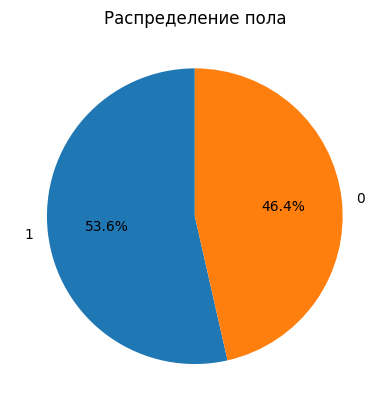

In [7]:
counts = y_train.value_counts()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Распределение пола')
plt.show()

In [8]:
class GridSearchRanges:
    selector_k = list(range(3, min(10, len(feature_cols)) + 1))
    svc_c = [0.01, 0.1, 1 ]
    svc_gamma = [ 0.1, 0.5, 1 ]
    logistic_c = [0.01, 0.1, 1 ]
    gb_criterion = [ 'friedman_mse', 'squared_error']
    tree_max_depth = [ 5, 6 ]
    tree_max_features = ['sqrt', 'log2', 6, 7]
    tree_n_estimators = [100, 150, 200 ]
    rf_criterion = ['gini', 'entropy']

In [14]:
num_model_accuracy = create_accuracy('selector__k', 5, 0.005)
all_model_accuracy = create_accuracy('features__num__selector__k', 5, 0.005)
separated_models_accuracy = create_accuracy('num_model__selector__k', 5, 0.005)

pipeline_grids = [
    (
        'LogisticRegression vect',
        PipelineBuilder(lambda : LogisticRegression(random_state=42, class_weight='balanced'), get_vect).build(), 
        {
            'model__C': GridSearchRanges.logistic_c,
        },
        'accuracy'
    ),
    (
        'LogisticRegression features',
        PipelineBuilder(lambda : LogisticRegression(random_state=42, class_weight='balanced'), get_num).use_std().use_kbest().build(), 
        {
            'selector__k': GridSearchRanges.selector_k,
            'model__C': GridSearchRanges.logistic_c,
        },
        num_model_accuracy
    ),
    (
        'SVC poly features',
        PipelineBuilder(lambda : SVC(kernel='poly', random_state=42, class_weight='balanced'), get_num).use_std().use_kbest().build(), 
        {
            'selector__k': GridSearchRanges.selector_k,
            'model__C': GridSearchRanges.svc_c,
            'model__degree': [2, 3 ]
        },
        num_model_accuracy
    ),
    (
        'SVC rbf features',
        PipelineBuilder(lambda : SVC(kernel='rbf', random_state=42, class_weight='balanced'), get_num).use_std().use_kbest().build(), 
        {
            'selector__k': GridSearchRanges.selector_k,
            'model__C': GridSearchRanges.svc_c,
            'model__gamma': GridSearchRanges.svc_gamma, 
        },
        num_model_accuracy
    ),
    (
        'Naive bayes features',
        PipelineBuilder(lambda : GaussianNB(), get_num).use_std().use_kbest().build(), 
        {
            'selector__k': GridSearchRanges.selector_k,
            'model__var_smoothing': [ 1e-8, 1e-7 ]
        },
        num_model_accuracy
    ),
    (
        'SVC rbf features & vect',
        PipelineBuilder(lambda : SVC(kernel='rbf', random_state=42, class_weight='balanced'), get_num).use_std().use_kbest().use_vect(get_vect).build(), 
        {
            'features__num__selector__k': GridSearchRanges.selector_k,
            'model__C': GridSearchRanges.svc_c,
            'model__gamma': GridSearchRanges.svc_gamma, 
        },
        all_model_accuracy
    ),
    (
        'LogisticRegression features & vect',
        PipelineBuilder(lambda : LogisticRegression(random_state=42, class_weight='balanced'), get_num).use_std().use_kbest().use_vect(get_vect).build(), 
        {
            'features__num__selector__k': GridSearchRanges.selector_k,
            'model__C': GridSearchRanges.logistic_c,
        },
        all_model_accuracy
    ),
    (
        'Naive bayes features & vect',
        PipelineBuilder(lambda : GaussianNB(), get_num).use_std().use_kbest().use_vect(get_vect).build(), 
        {
            'features__num__selector__k': GridSearchRanges.selector_k,
            'model__var_smoothing': [ 1e-8, 1e-7 ]
        },
        all_model_accuracy
    ),
    (
        'SVC rbf features + Logistic vect = Voting',
        (PipelineBuilder(lambda: SVC(kernel='rbf', random_state=42, probability=True), get_num).use_std().use_kbest()
            .use_vect(get_vect, lambda: LogisticRegression(random_state=42, class_weight='balanced'), (VotingClassifier, { 'voting': 'soft' }))
            .build()
        ),
        {
            'num_model__selector__k': GridSearchRanges.selector_k,
            'num_model__model__C': GridSearchRanges.svc_c,
            'num_model__model__gamma': GridSearchRanges.svc_gamma, 
            'vect_model__model__C': GridSearchRanges.logistic_c,
        },
        separated_models_accuracy
    ),
    (
        'SVC rbf features + Logistic vect = Stacking',
        (PipelineBuilder(lambda: SVC(kernel='rbf', random_state=42, probability=True), get_num).use_std().use_kbest()
            .use_vect(get_vect, lambda: LogisticRegression(random_state=42, class_weight='balanced'), (StackingClassifier, { }))
            .build()
        ),
        {
            'num_model__selector__k': GridSearchRanges.selector_k,
            # 'num_model__model__C': GridSearchRanges.svc_c,
            # 'num_model__model__gamma': GridSearchRanges.svc_gamma, 
            # 'vect_model__model__C': GridSearchRanges.logistic_c,
        },
        separated_models_accuracy
    ),
    (
        'SVC rbf features + SVC rbf = Voting',
        (PipelineBuilder(lambda: SVC(kernel='rbf', random_state=42, probability=True), get_num).use_std().use_kbest()
            .use_vect(get_vect, lambda: SVC(kernel='rbf', random_state=42, probability=True), (VotingClassifier, { 'voting': 'soft' }))
            .build()
        ),
        {
            'num_model__selector__k': GridSearchRanges.selector_k,
            # 'num_model__model__C': GridSearchRanges.svc_c,
            # 'num_model__model__gamma': GridSearchRanges.svc_gamma, 
            # 'vect_model__model__C': GridSearchRanges.svc_c,
            # 'vect_model__model__gamma': GridSearchRanges.svc_gamma,
        },
        separated_models_accuracy
    ),
    (
        'SVC rbf features + SVC rbf = Stacking',
        (PipelineBuilder(lambda: SVC(kernel='rbf', random_state=42, probability=True), get_num).use_std().use_kbest()
            .use_vect(get_vect, lambda: SVC(kernel='rbf', random_state=42, probability=True), (StackingClassifier, { }))
            .build()
        ),
        {
            'num_model__selector__k': GridSearchRanges.selector_k,
            # 'num_model__model__C': GridSearchRanges.svc_c,
            # 'num_model__model__gamma': GridSearchRanges.svc_gamma, 
            # 'vect_model__model__C': GridSearchRanges.svc_c,
            # 'vect_model__model__gamma': GridSearchRanges.svc_gamma
        },
        separated_models_accuracy
    )
]

In [15]:
best_models = get_best_models(pipeline_grids, X_train, y_train)

1 / 12
2 / 12
3 / 12
4 / 12
5 / 12
6 / 12
7 / 12


/home/skuld/repositories/nlp/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/skuld/repositories/nlp/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

8 / 12
9 / 12
10 / 12
11 / 12
12 / 12


In [48]:
evaluate_models(best_models, X_test, y_test)

--------------LogisticRegression vect--------------
model parameters: {'model__C': 1}
              precision    recall  f1-score   support

           0       0.60      0.64      0.62       811
           1       0.68      0.65      0.66       969

    accuracy                           0.64      1780
   macro avg       0.64      0.64      0.64      1780
weighted avg       0.65      0.64      0.64      1780

[[519 292]
 [341 628]]
AUC = 0.6440207467242852
--------------LogisticRegression features--------------
model parameters: {'model__C': 0.1, 'selector__k': 4}
selected features: ['x0' 'x4' 'x7' 'x12']
              precision    recall  f1-score   support

           0       0.70      0.91      0.79       811
           1       0.90      0.67      0.77       969

    accuracy                           0.78      1780
   macro avg       0.80      0.79      0.78      1780
weighted avg       0.81      0.78      0.78      1780

[[742  69]
 [322 647]]
AUC = 0.7913092552226291
------------

In [49]:
X_train_noises, X_test_noises, y_train_noises, y_test_noises, get_num_noises, get_vect_noises = prepare_input(noises_data, test_size, emb, feature_cols, target_col)

In [50]:
pipeline_grids_noises = [
    (
        'RandomForest vect',
        PipelineBuilder(lambda : RandomForestClassifier(random_state=42), get_vect_noises).build(), 
        {
            'model__criterion': GridSearchRanges.rf_criterion,
            'model__max_depth': GridSearchRanges.tree_max_depth,
            'model__n_estimators': GridSearchRanges.tree_n_estimators,
        },
        'accuracy'
    ),
    (
        'GradientBoosting vect',
        PipelineBuilder(lambda : GradientBoostingClassifier(random_state=42), get_vect_noises).build(), 
        {
            'model__criterion': GridSearchRanges.gb_criterion,
            'model__max_depth': GridSearchRanges.tree_max_depth,
            'model__n_estimators': GridSearchRanges.tree_n_estimators,
        },
        'accuracy'
    ),
    (
        'RandomForest features',
        PipelineBuilder(lambda : RandomForestClassifier(random_state=42), get_num_noises).build(), 
        {
            'model__criterion': GridSearchRanges.rf_criterion,
            'model__max_depth': GridSearchRanges.tree_max_depth,
            'model__max_features': GridSearchRanges.tree_max_features,
            'model__n_estimators': GridSearchRanges.tree_n_estimators,
        },
        'accuracy'
    ),
    (
        'GradientBoosting features',
        PipelineBuilder(lambda : GradientBoostingClassifier(random_state=42), get_num_noises).build(), 
        {
            'model__criterion': GridSearchRanges.gb_criterion,
            'model__max_depth': GridSearchRanges.tree_max_depth,
            'model__max_features': GridSearchRanges.tree_max_features,
            'model__n_estimators': GridSearchRanges.tree_n_estimators,
        },
        'accuracy'
    ),
    (
        'RandomForest features & vect',
        PipelineBuilder(lambda : RandomForestClassifier(random_state=42), get_num_noises).use_vect(get_vect_noises).build(), 
        {
            'model__criterion': GridSearchRanges.rf_criterion,
            'model__max_depth': GridSearchRanges.tree_max_depth,
            'model__n_estimators': GridSearchRanges.tree_n_estimators,
        },
        'accuracy'
    ),
    (
        'GradientBoosting features & vect',
        PipelineBuilder(lambda : GradientBoostingClassifier(random_state=42), get_num_noises).use_vect(get_vect_noises).build(), 
        {
            'model__criterion': GridSearchRanges.gb_criterion,
            'model__max_depth': GridSearchRanges.tree_max_depth,
            'model__n_estimators': GridSearchRanges.tree_n_estimators,
        },
        'accuracy'
    )
]

In [51]:
best_models_noises = get_best_models(pipeline_grids_noises, X_train_noises, y_train_noises)

1 / 6
2 / 6
3 / 6
4 / 6
5 / 6
6 / 6


In [52]:
evaluate_models(best_models_noises, X_test_noises, y_test_noises)

--------------RandomForest vect--------------
model parameters: {'model__criterion': 'gini', 'model__max_depth': 6, 'model__n_estimators': 100}
    feature  importance
87      x87    0.034478
16      x16    0.034204
195    x195    0.027520
39      x39    0.026322
120    x120    0.024822
184    x184    0.024251
70      x70    0.022997
291    x291    0.021720
28      x28    0.019667
268    x268    0.019082
              precision    recall  f1-score   support

           0       0.61      0.53      0.57      1090
           1       0.66      0.73      0.69      1355

    accuracy                           0.64      2445
   macro avg       0.63      0.63      0.63      2445
weighted avg       0.64      0.64      0.64      2445

[[573 517]
 [364 991]]
AUC = 0.628526693523816
--------------GradientBoosting vect--------------
model parameters: {'model__criterion': 'friedman_mse', 'model__max_depth': 6, 'model__n_estimators': 100}
    feature  importance
87      x87    0.040281
16      x16   

In [ ]:
#pipeline.set_params(**{ 'voting': 'hard'})